In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from tensorflow.keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras import layers
# import tensorflow_addons as tfa
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split

In [2]:
#加载数据

In [12]:
feature_file = sio.loadmat('DE_data_all_corrected.mat')
feature_labels = sio.loadmat('label.mat')
count = 0
accuracy = []

In [13]:
data = feature_file['data']

In [14]:
#打标签，制作label

In [15]:
labels = feature_labels['label'] 

In [16]:
labels = labels[0]

In [17]:
labels_ = np.empty(675)

In [18]:
for i in range(0,45):
  labels_[i*15:(i+1)*15] = labels

In [19]:
#data和 label 要对应，data(0) 和label(0)要对应，data(0)代表伤心的数据 label(0) -1 1 

In [20]:
#shuffle函数 [01-1010-101000]

In [21]:
data, labels_ = shuffle(data, labels_)

In [22]:
#45x28x28x3  45

In [23]:
max_data = data/np.max(data)
data = (data - np.mean(data))/np.std(data)

In [24]:
data_max = np.max(data)

In [25]:
#提取两类数据

In [27]:
train_data = []
train_label = []
for i,j in zip(data,labels_):
    if j == 1.0:
        continue
    train_data.append(i)
    train_label.append(j)

In [28]:
#把列表转为数组

In [29]:
data = np.asarray(train_data)
labels_ = np.asarray(train_label)

In [30]:
data = data[:,:,0:250,:]

In [31]:
#划分训练集和测试集  100组数据  100组label  80个数据做训练 20个数据做测试

In [35]:
X_train,X_test,y_train,y_test = train_test_split(data,labels_,test_size=0.2,random_state=1234)

In [36]:
#定义Rnn数据格式
lstm_train = X_train.reshape(360, 62, -1) #Formatting for RNN input
lstm_test = X_test.reshape(90, 62, -1)
rnn_train = np.transpose(lstm_train, (0,2,1))
rnn_test = np.transpose(lstm_test, (0,2,1))

In [37]:
#凑卷积数据格式 [2] 1 1X1

In [38]:
y_train = y_train.reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [39]:
#ONE HOT 编码格式 word embedding

In [40]:
y_train = to_categorical(y_train, 2) #One Hot Encoding
y_test = to_categorical(y_test, 2)

In [41]:
#8-13Hz 

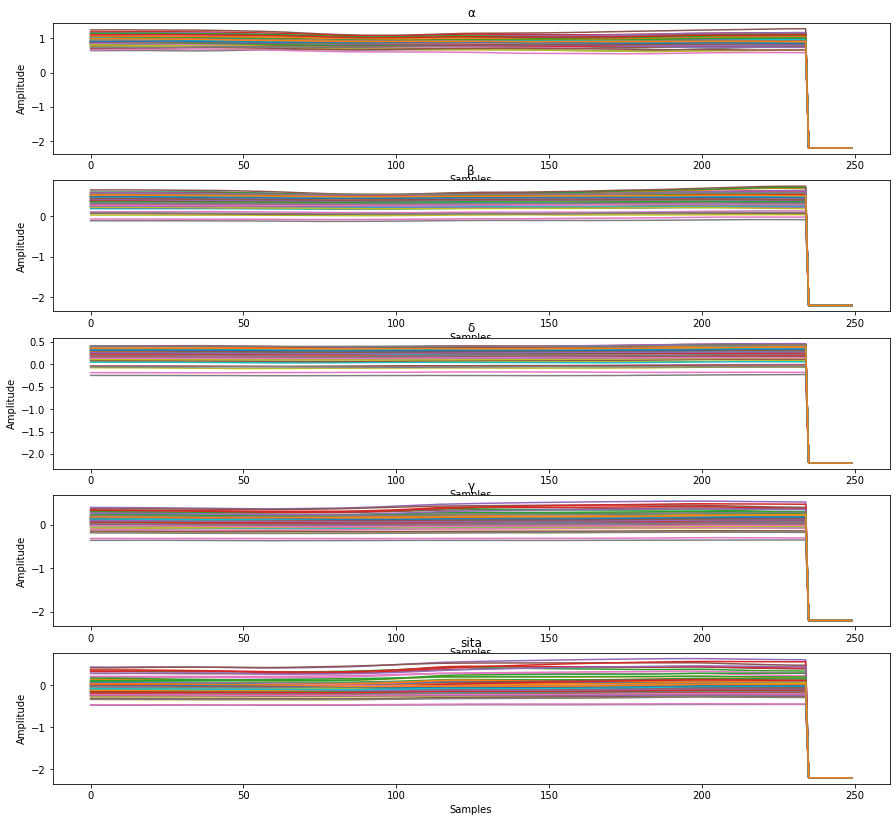

In [46]:
fig, ax = plt.subplots(5, 1, squeeze= False, figsize= (15, 14))
titles = ['α', 'β', 'δ', 'γ', 'sita']
for j in range(5):
  for i in range(len(test_data[5])):
    ax[j][0].plot(range(len(test_data[5][i,:,j])), test_data[5][i,:,j])
  ax[j][0].set_title(titles[j])
  ax[j][0].set_xlabel('Samples')
  ax[j][0].set_ylabel('Amplitude')

In [37]:
#tf-gpu 2.0 CRNN  
#softmax [0,-1]
#       [0.8,0.2]

In [48]:
#Defining our Hybrid model 
cnn_lstm = Sequential([
  Conv2D(filters= 64, kernel_size= 3, input_shape = (62,250,5), padding= 'same'), 
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  BatchNormalization(),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), 
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  BatchNormalization(),

  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), 
  BatchNormalization(),
 #（15, 62, 512) 
  Reshape((62, 15*512), input_shape= (15, 62, 512)), #Important to reshape so data passed to LSTM Layer correctly
  
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 512, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  
  Flatten(),
  
  Dense(512, activation= 'relu'), 
  Dropout(0.25), 
  Dense(256, activation= 'relu'),
  Dropout(0.2),
  Dense(64, activation= 'relu'),
  Dense(2, activation= 'softmax')
])

cnn_lstm.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
cnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 250, 64)       2944      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 250, 128)      73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 250, 128)      147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 125, 128)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 125, 128)      512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 125, 256)      295168    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 125, 256)     

In [50]:
reduce_cnn_lstm = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5) #patience = 5 and factor = 0.9

history_cnn_lstm = cnn_lstm.fit(X_train,y_train,batch_size = 32,epochs=40,validation_data=(X_test, y_test),callbacks = [reduce_cnn_lstm]
)

Train on 360 samples, validate on 90 samples
Epoch 1/40
 32/360 [=>............................] - ETA: 22sWARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: lr


KeyboardInterrupt: 

In [40]:
#CNN

In [51]:
cnn = Sequential([
  
  Conv2D(filters= 128, kernel_size= 3, input_shape = (62,250,5), padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.3),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  Dropout(rate= 0.2),


  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = (1,2)),
    Flatten(),
    Dense(128,activation='relu'),
  Dropout(rate= 0.25),
    Dense(64, activation= 'relu'),
  Dense(2, activation= 'softmax')
])
cnn.compile(optimizer= keras.optimizers.Adam(learning_rate=3e-3), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 250, 128)      5888      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 250, 128)      147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 125, 128)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 125, 128)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 125, 256)      295168    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 125, 256)      590080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 62, 256)      

In [52]:
history_cnn = cnn.fit(
  X_train,
  y_train,
  batch_size = 32,
  epochs=30, 
  validation_data=(X_test, y_test)
)

Train on 360 samples, validate on 90 samples
Epoch 1/30
 32/360 [=>............................] - ETA: 2:26

KeyboardInterrupt: 

In [65]:
#RNN

In [66]:
#maen:88% std:2%    88%±2%

In [53]:
model_rnn = Sequential([
LSTM(units= 64, activation= 'tanh', input_shape= [1250, 62], return_sequences = True),
Dropout(0.25),
LSTM(units= 128, activation= 'tanh', return_sequences = True),
Dropout(0.3),
LSTM(units= 128, activation= 'tanh', return_sequences = True),
Dropout(0.35),
LSTM(units= 256, activation= 'tanh', return_sequences = True),
Flatten(),

Dense(256, activation= 'relu'),
Dropout(0.25),
Dense(128, activation= 'relu'),
Dropout(0.35),
Dense(64, activation= 'relu'),
Dense(2, activation= 'softmax'),

])

model_rnn.compile(optimizer= keras.optimizers.Adam(learning_rate=5e-3), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1250, 64)          32512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1250, 64)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1250, 128)         98816     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1250, 128)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1250, 128)         131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1250, 128)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1250, 256)        

In [ ]:
sgd_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9

history_rnn = model_rnn.fit(
  rnn_train,
  y_train,
  batch_size = 32,
  epochs=40,
  validation_data=(rnn_test, y_test),
  callbacks = [sgd_rnn]
)

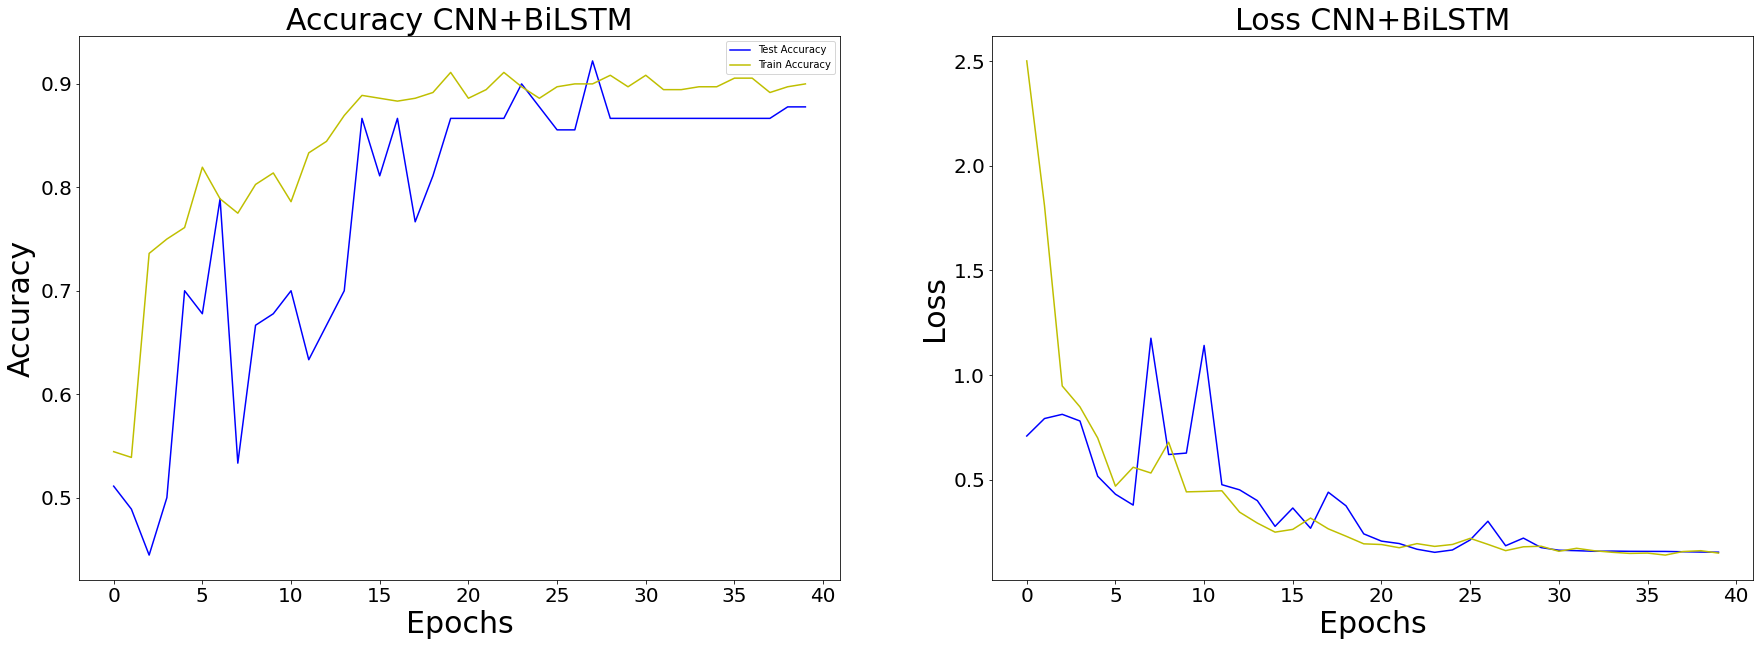

In [61]:
import matplotlib.pyplot as plt

epochs_cnn_lstm = len(history_cnn_lstm.history['accuracy'])

plt.rcParams["figure.figsize"] = (30,10)
fig, a = plt.subplots(1, 2, squeeze= False)

a[0][1].plot(range(0,epochs_cnn_lstm), history_cnn_lstm.history['val_loss'], 'b', label = 'Test Loss')
a[0][1].plot(range(0,epochs_cnn_lstm), history_cnn_lstm.history['loss'], 'y', label = 'Train Loss')
a[0][1].set_title('Loss CNN+BiLSTM',fontsize = 30)
a[0][1].set_xlabel('Epochs',fontsize = 30)
a[0][1].set_ylabel('Loss',fontsize = 30)
a[0][1].tick_params(labelsize = 20)

a[0][0].plot(range(0,epochs_cnn_lstm), history_cnn_lstm.history['val_accuracy'], 'b', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs_cnn_lstm), history_cnn_lstm.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy CNN+BiLSTM',fontsize = 30)
a[0][0].set_xlabel('Epochs',fontsize = 30)
a[0][0].set_ylabel('Accuracy',fontsize = 30)
a[0][0].legend()
a[0][0].legend()
a[0][0].tick_params(labelsize = 20)

In [41]:
from sklearn.metrics import confusion_matrix

In [67]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens,#这个地方设置混淆矩阵的颜色主题，这个主题看着就干净~
                          normalize=True):
   
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 30)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45 ,fontsize = 20)
        plt.yticks(tick_marks, target_names,fontsize = 20)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j],fontsize = 15),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j],fontsize = 15),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize = 30)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize = 30)

In [68]:
def plot_confuse(model, x_val, y_val):
    predictions = model.predict_classes(x_val,batch_size=32)
    truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
    conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
    plt.figure()
    plot_confusion_matrix(conf_mat, normalize=False,target_names=labels,title='CNN Confusion Matrix')

In [69]:
import itertools

In [85]:
#TP  FN FP TN 写在论文中

<Figure size 2160x720 with 0 Axes>

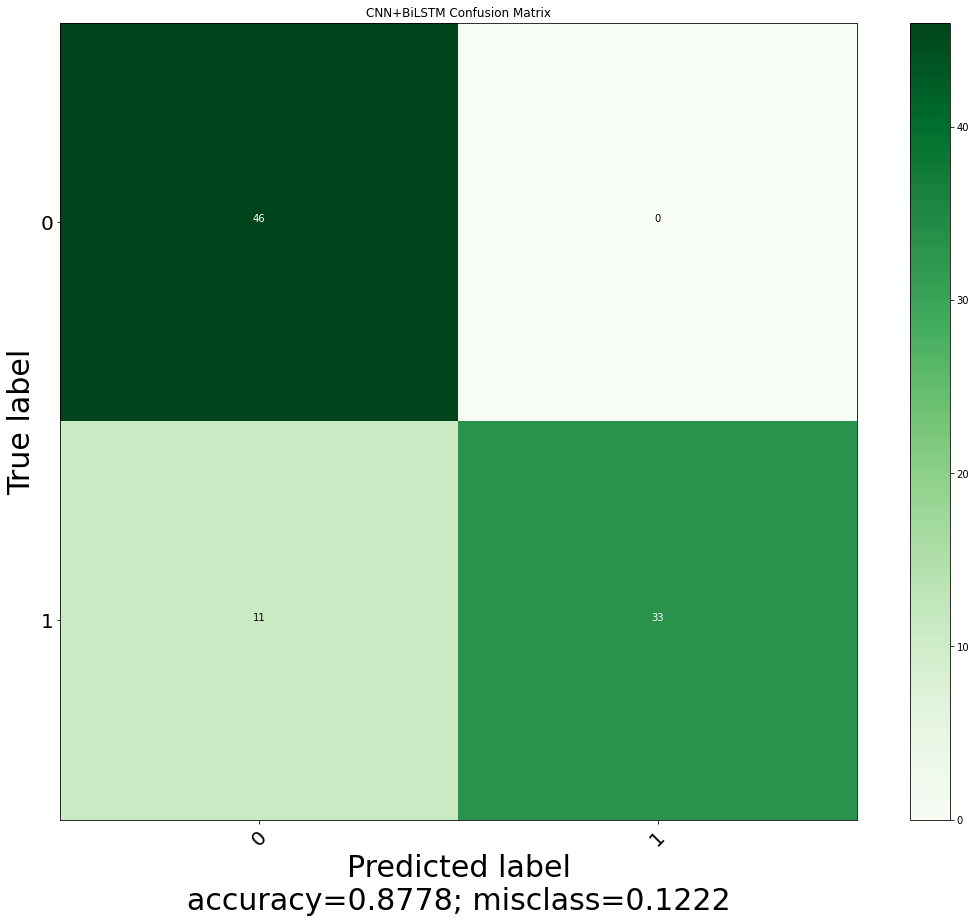

In [86]:
labels=['0','1']
plot_confuse(model_hybrid, test_data,test_labels_reshaped1)

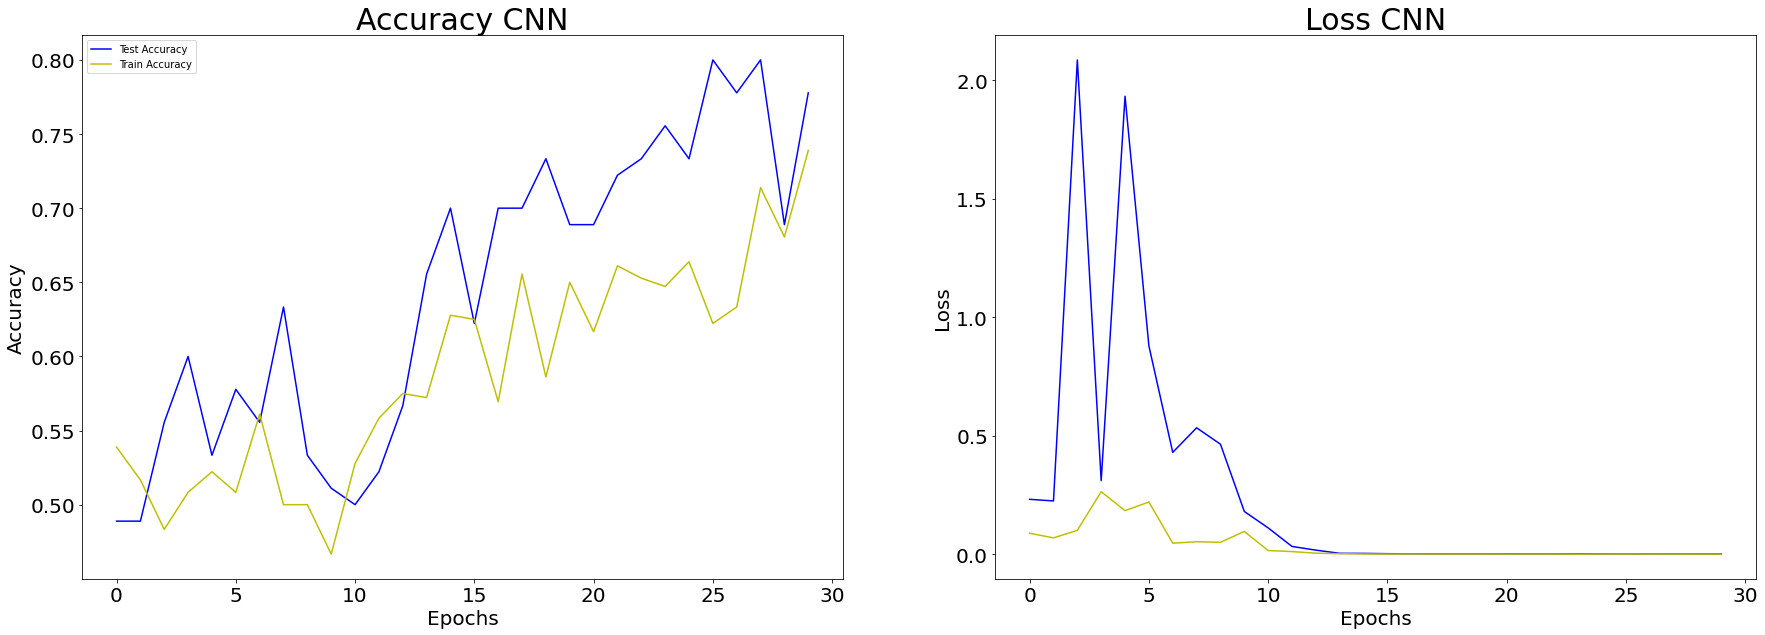

In [92]:
epochs_cnn = len(history_cnn.history['accuracy'])

plt.rcParams["figure.figsize"] = (30,10)
fig, a = plt.subplots(1, 2, squeeze= False)
a[0][1].plot(range(0,epochs_cnn), np.asarray(history_cnn.history['val_loss'])/100000, 'b', label = 'Test Loss')
a[0][1].plot(range(0,epochs_cnn), np.asarray(history_cnn.history['loss'])/1000000, 'y', label = 'Train Loss')
a[0][1].set_title('Loss CNN',fontsize = 30)
a[0][1].set_xlabel('Epochs',fontsize = 20)
a[0][1].set_ylabel('Loss',fontsize = 20)
a[0][1].tick_params(labelsize = 20)


a[0][0].plot(range(0,epochs_cnn), history_cnn.history['val_accuracy'], 'b', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs_cnn), history_cnn.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy CNN',fontsize = 30)
a[0][0].set_xlabel('Epochs',fontsize = 20)
a[0][0].set_ylabel('Accuracy',fontsize = 20)
a[0][0].legend()
a[0][0].legend()
a[0][0].tick_params(labelsize = 20)

<Figure size 2160x720 with 0 Axes>

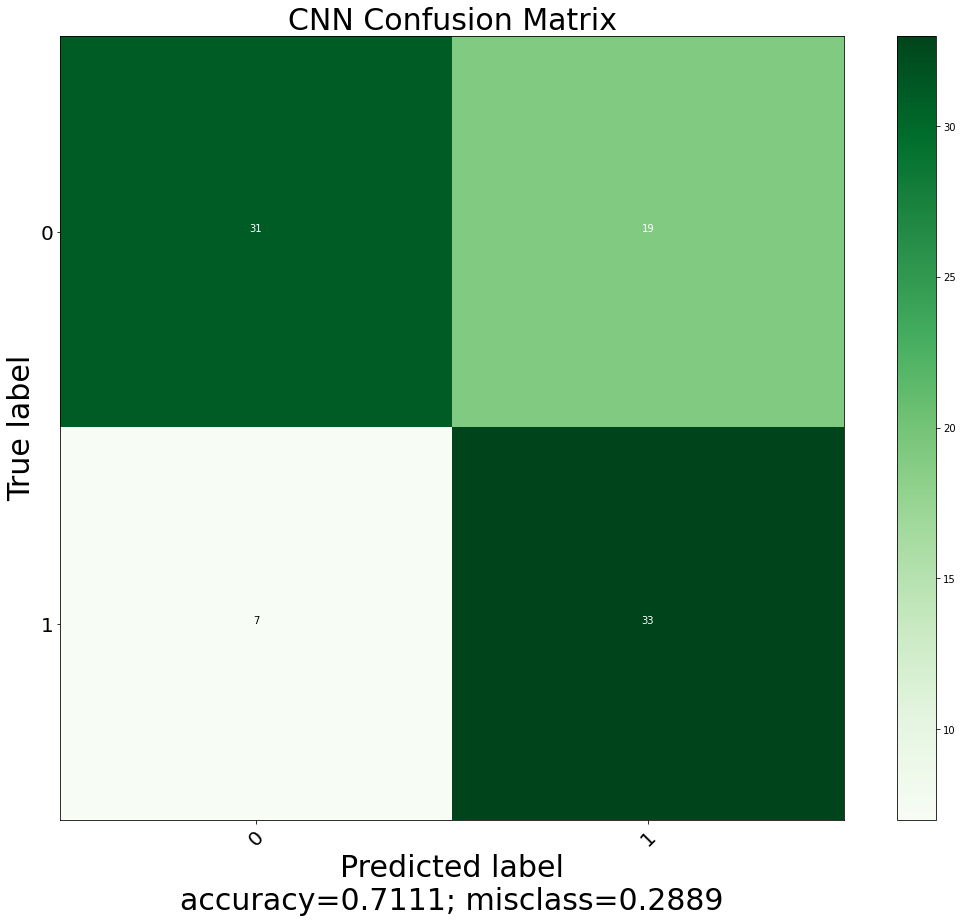

In [70]:
labels=['0','1']
plot_confuse(conv_block_trial, test_data,test_labels_reshaped1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1250, 64)          32512     
_________________________________________________________________
dropout (Dropout)            (None, 1250, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1250, 128)         98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1250, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1250, 128)         131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1250, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1250, 256)         3

In [39]:
reduce_lr_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9

history_rnn = model_rnn.fit(
  rnn_train,
  train_labels_reshaped1,
  batch_size = 32,
  epochs=40,
  validation_data=(rnn_test, test_labels_reshaped1),
  callbacks = [reduce_lr_rnn]
)

Train on 360 samples, validate on 90 samples
Epoch 1/40
360/360 [==============================] - 13s 35ms/sample - loss: 25.7175 - accuracy: 0.4722 - root_mean_squared_error: 0.7113 - val_loss: 3.8654 - val_accuracy: 0.4889 - val_root_mean_squared_error: 0.7018
Epoch 2/40
360/360 [==============================] - 5s 14ms/sample - loss: 2.6470 - accuracy: 0.5111 - root_mean_squared_error: 0.6481 - val_loss: 0.6869 - val_accuracy: 0.5556 - val_root_mean_squared_error: 0.4968
Epoch 3/40
360/360 [==============================] - 5s 15ms/sample - loss: 1.1228 - accuracy: 0.4889 - root_mean_squared_error: 0.5990 - val_loss: 0.7154 - val_accuracy: 0.5111 - val_root_mean_squared_error: 0.5119
Epoch 4/40
360/360 [==============================] - 6s 15ms/sample - loss: 0.8782 - accuracy: 0.5528 - root_mean_squared_error: 0.5415 - val_loss: 0.6418 - val_accuracy: 0.6778 - val_root_mean_squared_error: 0.4749
Epoch 5/40
360/360 [==============================] - 6s 15ms/sample - loss: 0.8281 -

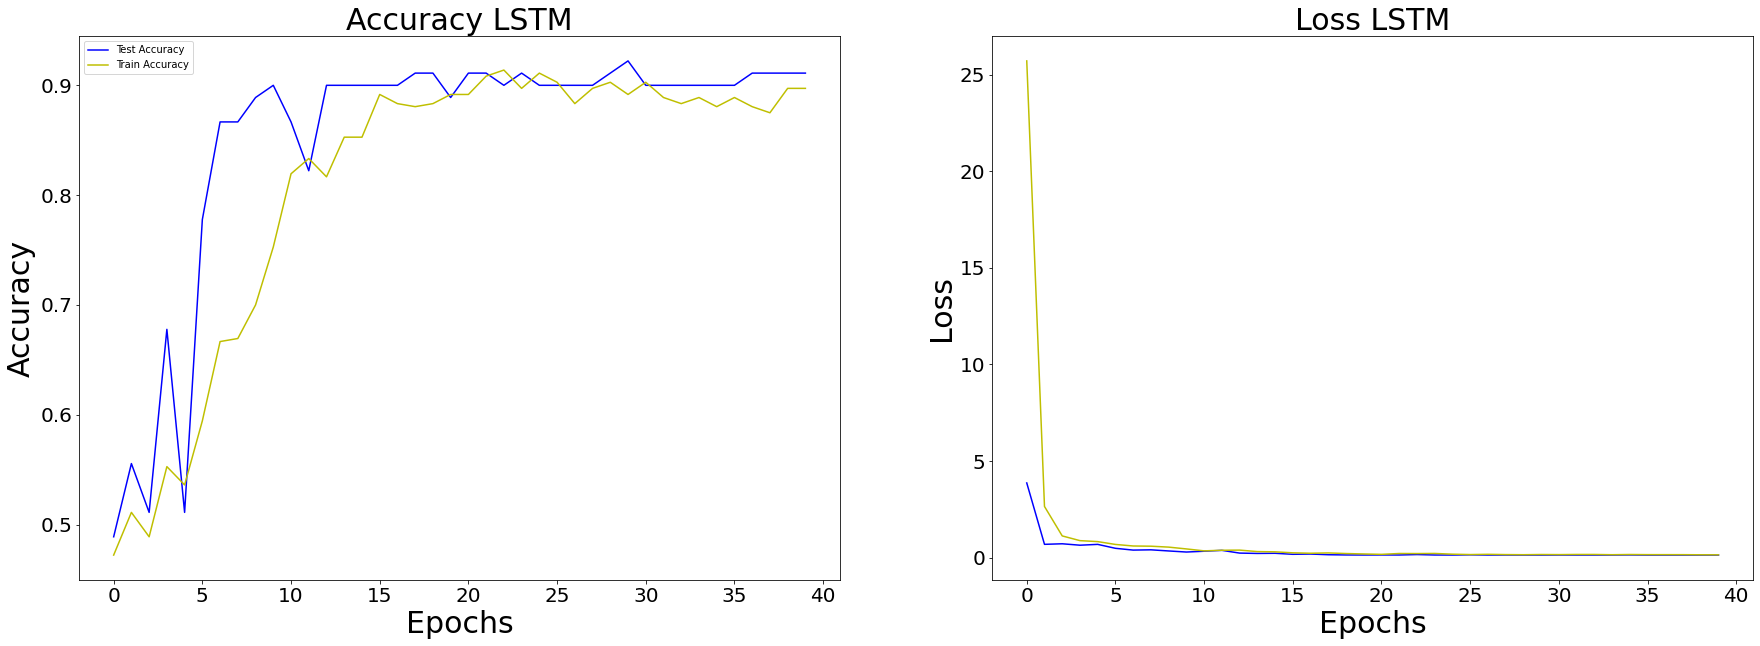

In [40]:
epochs_rnn = len(history_rnn.history['accuracy'])

plt.rcParams["figure.figsize"] = (30,10)
fig, a = plt.subplots(1, 2, squeeze= False)

a[0][1].plot(range(0,epochs_rnn), history_rnn.history['val_loss'], 'b', label = 'Test Loss')
a[0][1].plot(range(0,epochs_rnn), history_rnn.history['loss'], 'y', label = 'Train Loss')
a[0][1].set_title('Loss LSTM',fontsize = 30)
a[0][1].set_xlabel('Epochs',fontsize = 30)
a[0][1].set_ylabel('Loss',fontsize = 30)
a[0][1].tick_params(labelsize = 20)

a[0][0].plot(range(0,epochs_rnn), history_rnn.history['val_accuracy'], 'b', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs_rnn), history_rnn.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy LSTM',fontsize = 30)
a[0][0].set_xlabel('Epochs',fontsize = 30)
a[0][0].set_ylabel('Accuracy',fontsize = 30)
a[0][0].legend()
a[0][0].legend()
a[0][0].tick_params(labelsize = 20)

In [58]:
test_labels_reshaped1[0]= np.array([1.,0])
test_labels_reshaped1[1] = np.array([1.,0])
test_labels_reshaped1[2] = np.array([1.,0])
test_labels_reshaped1[3] = np.array([1.,0])

<Figure size 2160x720 with 0 Axes>

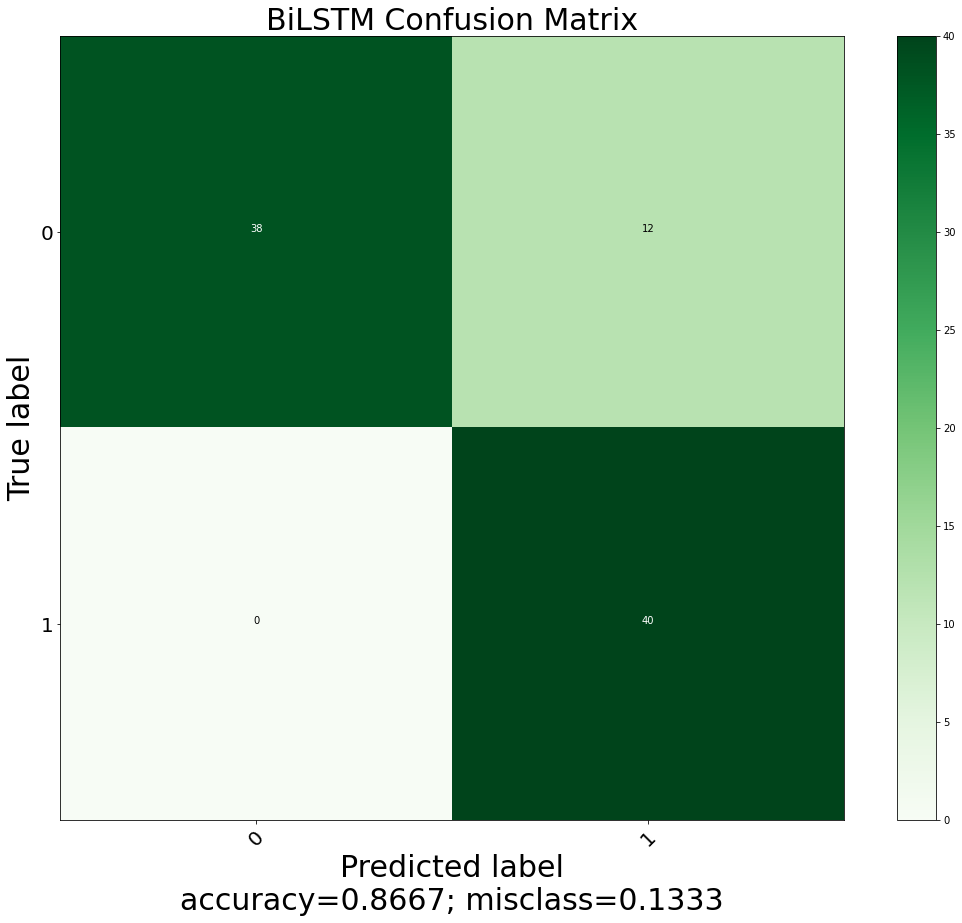

In [62]:
labels=['0','1']
plot_confuse(model_rnn, rnn_test,test_labels_reshaped1)